 the last version on model , get train and test data, add GDPR (RE) and then add dic to list and in the last there is evaluation for model

In [1]:
import pandas as pd
import spacy
import random
from spacy.util import minibatch, compounding
from spacy.training.example import Example

2023-06-21 10:43:28.836948: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 10:43:28.929669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 10:43:29.847145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Encoding

In [4]:
from subprocess import check_output
print(check_output(["ls", "/home/jovyan/work/data/label_data"]).decode("utf8"))

extra
ner.csv
nerReformat.csv
ner_test_data.csv
ner_train_data.csv
newner_test_data.csv
newner_train_data4.csv
newner_train_data.csv



In [5]:
def reformat_data_spacy_format(data):
    grouped = data.groupby("sentence_idx").apply(
        lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["tag"].values.tolist())])
    sentences = [s for s in grouped]
    data_encoded = []
    for s in sentences:
        full_s = ""
        start_index = 0
        last_index = 0
        index_counter = 0
        entities = []
        for w in s:
            full_s += str(w[0]) + " "
            entities.append((index_counter, index_counter + len(str(w[0])), w[1]))
            index_counter += len(str(w[0])) + 1
        data_encoded.append((full_s, {"entities": entities}))

    return data_encoded


In [39]:
train_df = pd.read_csv("/home/jovyan/work/data/health/lstm/train.csv")
# test_df = pd.read_csv("/home/jovyan/work/data/health/lstm/test.csv")
test_df = pd.read_csv("/home/jovyan/work/data/hybrid/lstm_output.csv", low_memory=False)
train_data = reformat_data_spacy_format(train_df)
test_data = reformat_data_spacy_format(test_df)


# Initialize spaCy model

In [11]:
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
# Create the NER component
ner = nlp.get_pipe("ner")

In [12]:
# Initialize the matcher
matcher = Matcher(nlp.vocab)

### Define Custom Pattern
# Define a pattern using regular expressions
email_pattern = r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$"
bsn_pattern = r"\b\d{9}\b"
phone_pattern = r"\b[\d()+-]{8,20}\b"
id_number_pattern = r"\b[A-Za-z0-9]{6,20}\b"
passport_pattern = r"\b[A-Za-z0-9]{6,20}\b"
credit_card_pattern = r"\b\d{13,19}\b"
bank_account_pattern = r"\b[A-Za-z0-9]{6,30}\b"
matcher.add("EMAIL", [[{"TEXT": {"REGEX": email_pattern}}]])
matcher.add("IDNUM", [[{"TEXT": {"REGEX": bsn_pattern}}]])
matcher.add("PHONE", [[{"TEXT": {"REGEX": phone_pattern}}]])
matcher.add("IDNUM", [[{"TEXT": {"REGEX": id_number_pattern}}]])
matcher.add("IDNUM", [[{"TEXT": {"REGEX": passport_pattern}}]])
matcher.add("IDNUM", [[{"TEXT": {"REGEX": credit_card_pattern}}]])
matcher.add("IDNUM", [[{"TEXT": {"REGEX": bank_account_pattern}}]])
# Adding
# NORP(Nationalities or Religious or Political
# Groups)
religious_words = ["Christianity", "Islam", "Secular", "Nonreligious", "Agnostic", "Atheist", "Hinduism", "Buddhism",
                   "Chinese traditional religion[c]", "Ethnic religions", "African traditional religions", "Sikhism",
                   "Spiritism", "Judaism", "Bahá'í", "Jainism", "Shinto", "Cao Dai", "Zoroastrianism", "Tenrikyo",
                   "Animism", "Neo-Paganism", "Unitarian Universalism", "Rastafari"]

religion_pattern_1 = [
    {"LOWER": {"IN": religious_words}},
    {"POS": "NOUN"},
]

religion_pattern_2 = [
    {"IS_TITLE": True, "POS": "NOUN"},
    {"ENT_TYPE": "NORP"}
]
matcher.add("NORP", [religion_pattern_1, religion_pattern_2])
### Degree

degree_pattern_1 = [
    {"LOWER": {"IN": ["bachelor's", "bachelors", "master's", "masters"]}},
    {"POS": "NOUN"}
]

degree_pattern_2 = [
    {"IS_TITLE": True, "POS": "NOUN"},
    {"ENT_TYPE": "DEGREE"}
]

# add degree_pattern to the matcher
matcher.add("DEGREE_PATTERN", [degree_pattern_1, degree_pattern_2])

In [13]:
# Add custom tags to the NER pipeline
for _, annotations in train_data:
    for entity in annotations.get("entities"):
        ner.add_label(entity[2])

# Disable unnecessary pipeline components
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]


Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 31779.913611959117}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 21838.008260853967}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 19163.513533263143}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 17665.59713237672}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 16591.71323974175}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 15645.054440369042}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 15128.633613759974}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 14503.254356988977}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 13923.93486349945}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 13521.444135744572}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 13120.620203791072}
Losses: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 12838.425366164556}
Losses: {'tok2vec':

TypeError: unhashable type: 'dict'

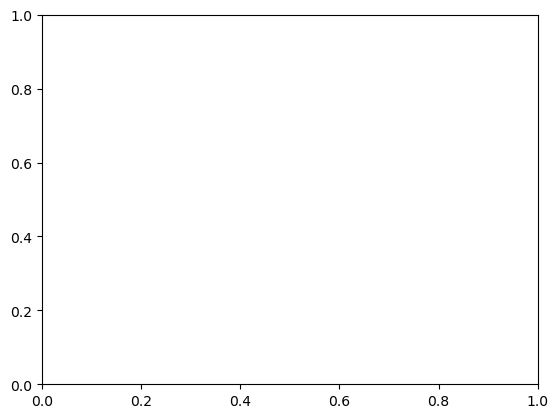

In [14]:
from matplotlib import pyplot as plt

# TRAINING THE MODEL
with nlp.disable_pipes():
    # Training iterations...
    for iteration in range(30):
        # Shuffle training examples before every iteration
        random.shuffle(train_data)
        losses = {}
        examples = []

        # Create Example objects from training data
        for text, annotation in train_data:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotation)
            examples.append(example)

        # Batch up the examples using spaCy's minibatch
        batches = minibatch(examples, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            nlp.update(batch, drop=0.5, losses=losses)

        print("Losses:", losses)

    # Plotting the loss values
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, '-')

    # Rest of the code remains the same
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.show()


{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 9941.029302601828}


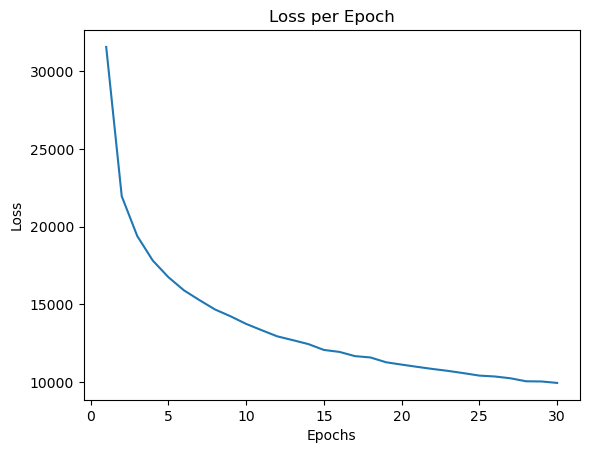

In [31]:
print(losses)
an = [31579.876175372396, 21962.675928107732, 19394.363777330516, 17816.52476117336, 16751.233077647532, 15903.905430979836, 15271.50361616444, 14671.321132600133, 14231.43657245629, 13742.654800908696, 13336.032287103297, 12941.100705722156, 12696.43275197662, 12442.51849748573, 12064.893154643087, 11939.323317979262, 11666.812288319059, 11580.06046464599, 11271.16553470416, 11120.355088367753, 10976.786931819637, 10838.530229825608, 10714.15913654403, 10568.386877051906, 10412.91492869988, 10355.397461062297, 10239.406306247927, 10047.326240390887, 10034.55156502354,9941.029302601828]

# Extracting loss values from the dictionary
loss_values = list(losses.values())

# Plotting the loss values with a line
epochs = range(1, len(an) + 1)
plt.plot(epochs, an, '-')

# Rest of the code remains the same
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.show()


In [25]:
# Save the trained model
output_dir = "/home/jovyan/work/data/output/spacyModel-health-epoch30-GDPR"
nlp.to_disk(output_dir)

### Evaluation
- Evaluation Per TAG
- General Evaluation

In [15]:
#Evaluation Per TAG
test_examples = []
for text, annotation in test_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotation)
    test_examples.append(example)

# Evaluate the model on the test set
scores = nlp.evaluate(test_examples)

# Calculate accuracy, precision, recall, and F1 score for each tag
tag_metrics = {}
for tag, values in scores['ents_per_type'].items():
    precision = round(values['p'] * 100, 2)  # Convert precision to percentage and round to 2 decimal places
    recall = round(values['r'] * 100, 2)  # Convert recall to percentage and round to 2 decimal places
    f1 = round(values['f'] * 100, 2)  # Convert F1 score to percentage and round to 2 decimal places

    tag_metrics[tag] = {'accuracy': precision, 'precision': precision, 'recall': recall, 'f1': f1}


from tabulate import tabulate

sorted_tags = sorted(tag_metrics.items(), key=lambda x: x[0])
table_data = []
for tag, metrics in sorted_tags:
    row = [tag, metrics['precision'], metrics['f1'], metrics['recall']]
    table_data.append(row)

table_headers = ["Tag", "Precision", "F1 Score", "Recall"]
table = tabulate(table_data, headers=table_headers, tablefmt="plain", colalign=("left", "left", "left", "left"))

print(table)


Tag                   Precision    F1 Score    Recall
-1                    0            0           0
-required             0            0           0
/and                  0            0           0
0                     0            0           0
0.01                  0            0           0
0.01(T                0            0           0
11                    0            0           0
130                   0            0           0
20                    0            0           0
200s                  0            0           0
28                    0            0           0
30                    0            0           0
33                    0            0           0
40.6&lt               0            0           0
42                    0            0           0
470                   0            0           0
50                    0            0           0
500                   0            0           0
6                     0            0           0
60             

In [22]:
 entity_metrics = scores['ents_per_type']

precision_sum = 0.0
recall_sum = 0.0
f_score_sum = 0.0
num_entity_types = len(entity_metrics)

for entity_type, metrics in entity_metrics.items():
    precision_sum += metrics['p']
    recall_sum += metrics['r']
    f_score_sum += metrics['f']

general_precision = precision_sum / num_entity_types
general_recall = recall_sum / num_entity_types
general_f_score = f_score_sum / num_entity_types

print("General Precision:", general_precision)
print("General Recall:", general_recall)
print("General F-Score:", general_f_score)

General Precision: 0.61519743230898
General Recall: 0.5015649871204919
General F-Score: 0.5379759018578586


### Restoring out put file

In [29]:
y_pred_spacy = []
y_true = []
# print(len(test_data))
# Prepare the texts for batch processing
texts = [word if (not pd.isnull(word) and word != '') else '<OOV>' for word in test_df['word']]

# Process the texts using the loaded spaCy model
docs = nlp.pipe(texts)

# Iterate over each processed document
for doc in docs:
    # Get the predicted tag or assign a placeholder value
    predicted_tag = doc[0].ent_type_ if doc else 'O'

    # Add the predicted tag to the y_pred_spacy list
    y_pred_spacy.append(predicted_tag)

# Create the results dataframe
results = pd.DataFrame({'word': texts, 'y_pred_spacy': y_pred_spacy})

# Print the results
print(results)


            word y_pred_spacy
0             55        B-AGE
1             yo            O
2              f            O
3       presents            O
4           Seen            O
...          ...          ...
826574        WY      B-STATE
826575        WY      B-STATE
826576        WY      B-STATE
826577        WY      B-STATE
826578        WY      B-STATE

[826579 rows x 2 columns]


In [49]:
test_df['y_pred_spacy'] = y_pred_spacy

# final_df = pd.DataFrame({})
count_equal = (results['y_pred_spacy'] == test_df['tag']).sum()
# test_df = test_df.dropna(axis=1, how='all')
# Print the count
print(test_df.head())
test_df.to_csv("/home/jovyan/work/data/hybrid/spacy_output.csv")

   Unnamed: 0  sentence_idx      word    tag y_pred_lstm Unnamed: 5  \
0           0             1        55  B-AGE           O        NaN   
1           1             1        yo      O           O        NaN   
2           2             1         f      O           O        NaN   
3           3             1  presents      O           O        NaN   
4           4             1      Seen      O           O        NaN   

  Unnamed: 6 Unnamed: 7 Unnamed: 8 y_pred_spacy  
0        NaN        NaN        NaN        B-AGE  
1        NaN        NaN        NaN            O  
2        NaN        NaN        NaN            O  
3        NaN        NaN        NaN            O  
4        NaN        NaN        NaN            O  


In [51]:
test_df.to_csv("/home/jovyan/work/data/hybrid/spacy_output.csv")

In [55]:
results = pd.DataFrame({'sentence_idx':test_df['sentence_idx'],'word': test_df['word'],'tag': test_df['tag'],
                        'y_pred_lstm': test_df['y_pred_lstm'], 'y_pred_spacy': y_pred_spacy})

In [57]:
results.to_csv("/home/jovyan/work/data/hybrid/spacy_output.csv")